In [ ]:
import cvxpy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from copy import deepcopy

import math

# from google.colab import drive
# drive.mount('/content/gdrive')

# Task 1

Optimize function:
$$
f(x) = (Qx, x) + (c, x)
$$ 

## Task 1.1
### Implement gradient descent with 
- with step-size $\gamma_k$ chosen optimally (exact line search):

$$ 
f(x + \gamma p) = \dfrac{1}{2} (Q (x + \gamma p), (x + \gamma p)) + (c, (x + \gamma p)) \rightarrow \underset{\gamma}{min} \\
f(x + \gamma p) = \dfrac{1}{2} (x + \gamma p)^\top Q (x + \gamma p) + c^\top (x + \gamma p) \rightarrow min \implies \\ 
\dfrac{d}{d \gamma} f(x + \gamma p) = \dfrac{1}{2} x^\top Q p + \dfrac{1}{2} p^\top Q x + \gamma p^\top Q p + c^\top p = 0 \\
\gamma = -\dfrac{(c^\top + \dfrac{1}{2} x^\top Q) p + \dfrac{1}{2} Qx}{p^\top Q p}  \implies
\begin{cases}
  \gamma = -\dfrac{\alpha p + \beta}{2 p^\top Q p} \\
  \alpha = c^\top + x^\top Q \\
  \beta = Qx
\end{cases}
$$

```
For further convenience, we can calculate step size with respect to set of equations above. 
```

- with step-size chosen by golden-ratio search method.

  https://en.wikipedia.org/wiki/Golden-section_search
- with step-size chosen by Armijo rule.
  
  http://page.math.tu-berlin.de/~kandler/Hanoi2013/Lecture_NLO/bms-basic-NLP_120609.pdf p. 16-17
  

## Task 1.2
### Implement coordinate descent with interleaving directions

- with step-size chosen optimally (exact line search)
  
  <strong>From previuos subtask</strong>
  
- with step-size chosen by Fibonacci method

  http://web.tecnico.ulisboa.pt/mcasquilho/compute/com/,Fibonacci/pdfHXu_ch1.pdf, p.13

In [ ]:
class Descent:
    """
    
    Class implement descent procedure, with 
    input function, gradient and step chooser

    """

    arg_losses = []
    fun_losses = []
    grad_sizes = []
    fun_values = []
    x_value = []

    optimal_x, optimal_f = None, None

    def __init__(self, function: callable, gradient: callable,
                 step_chooser=None, hessian=None):
        """

        :param function: optimized function
        :param gradient: gradient
        :param step_chooser: step-size chosing procedure
        :param hessian: optional
        """

        self.function = function
        self.gradient = gradient
        self.step_chooser = step_chooser
        self.hessian = hessian

        self._update()

    def _update(self):
        """

        :return: update self info
        """
        self.arg_losses = []
        self.fun_losses = []
        self.grad_sizes = []
        self.fun_values = []
        self.x_value = []

    def _save_results(self, x, fun_value, grad_size,
                      arg_loss, fun_loss):
        """
          save procedure for plotting 

        :param x:
        :param fun_value:
        :param grad_size:
        :param arg_loss:
        :param fun_loss:
        :return:
        """
        self.x_value += [x]
        self.arg_losses += [arg_loss]
        self.fun_losses += [fun_loss]
        self.grad_sizes += [grad_size]
        self.fun_values += [fun_value]

    def _optimal_step(self, x, *args, default_step=0.1):
        """
         optimal step calculation
        :param x: 
        :param default_step:
        :return:
        """

        step = self.step_chooser(x, *args)

        if np.isnan(step):
            return default_step
        else:
            return step

    def _coordinate_descent(self, x_init, tol=1e-3, max_iter=25):
        """
        implementation of coordinate descent
        :param x_init:
        :param tol:
        :param max_iter:
        :return:
        """
        success = False
        x_optimal, f_optimal = None, None
        iters = -1

        steps = []

        dimension, _ = x_init.shape
        E = np.eye(dimension)

        x_next, x_prev = deepcopy(x_init), deepcopy(x_init)

        for iter_num in range(max_iter):

            x_prev = deepcopy(x_next)       
            grad = self.gradient(x_prev)
            
            # START: best direction search
            best_direction_num = iter_num % dimension
            best_direction = np.array([E[best_direction_num]]).T
            best_step = self._optimal_step(x_prev, best_direction, iter_num)

            # for direction_num in range(0, dimension):
            #     direction = np.array([E[direction_num]]).T
            #     step = self._optimal_step(x_prev, direction)
            #
            #     if self.function(x_prev - step * grad[direction_num, 0] * direction) < self.function(
            #             x_prev - best_step * grad[best_direction_num, 0] * best_direction):
            #         best_direction = deepcopy(direction)
            #         best_step = deepcopy(step)
            #         best_direction_num = direction_num
            # FINISH: best direction search

            
            x_next = x_prev + best_step * best_direction

            arg_loss = np.linalg.norm(x_next - x_prev)
            fun_loss = np.linalg.norm(self.function(x_next) - self.function(x_prev))
            grad_size = np.linalg.norm(grad)
            fun_value = self.function(x_prev)

            steps.append(best_step)

            self._save_results(x_prev, fun_value, grad_size, arg_loss, fun_loss)

            if grad_size < tol:
                x_optimal = x_prev
                success = True
                iters = iter_num
                break

        if not success:
            x_optimal = x_next

        f_optimal = self.function(x_optimal)

        return x_optimal, f_optimal, iters, success

    def _gradient_descent(self, x_init, tol=1e-3, max_iter=25):
        """
        implementation of gradient descent
        :param x_init:
        :param tol:
        :param max_iter:
        :return:
        """

        success = False
        x_optimal, f_optimal = None, None
        iters = -1

        x_next, x_prev = deepcopy(x_init), deepcopy(x_init)

        for iter_num in range(max_iter):

            x_prev = deepcopy(x_next)

            grad = self.gradient(x_prev)
            step = self._optimal_step(x_prev, grad, iter_num)

            x_next = x_prev - step * grad

            arg_loss = np.linalg.norm(x_next - x_prev)
            fun_loss = np.linalg.norm(self.function(x_next) - self.function(x_prev))
            grad_size = np.linalg.norm(grad)
            fun_value = self.function(x_prev)

            self._save_results(x_prev, fun_value, grad_size, arg_loss, fun_loss)

            if grad_size < tol:
                x_optimal = x_prev
                success = True
                iters = iter_num
                break

        if not success:
            x_optimal = x_next

        f_optimal = self.function(x_optimal)

        return x_optimal, f_optimal, iters, success

    def optimize(self, x_init, tol=1e-3, max_iter=25, method='gradient-descent'):
        """        
        main procedure for calculations
        :param x_init:
        :param tol:
        :param max_iter:
        :param method:
        :return:
        """

        self._update()

        x, f, iters, success = -1, -1, -1, False

        if method == 'gradient-descent':
            x, f, iters, success = self._gradient_descent(x_init=x_init, tol=tol, max_iter=max_iter)
        elif method == 'coordinate-descent':
            x, f, iters, success = self._coordinate_descent(x_init=x_init, tol=tol, max_iter=max_iter)

        result = {
            'x': x,
            'f': f,
            'iters': iters,
            'success': success,
            'method': method
        }
        
        self.x_optimal = x
        self.f_optimal = f

        return result

In [ ]:
Q, c = np.array([[1.06515021, 1.29457678], [1.29457678, 2.53821185]]), np.array([[0.08233798, 3.87963941]]).T
x_start = np.array([[-10, 10]]).T

In [ ]:
def plot_results(l_b = -10, r_b = 10, n = 100, optimizer = None, title=''):
  l_b, r_b = -10, 10
  n = 100

  x = np.linspace(l_b, r_b, n)
  X, Y = np.meshgrid(x, x)
  Z = np.zeros(X.shape)

  for i in range(n):
    for j in range(n):
      Z[i, j] = function(np.array((X[i, j], Y[i, j])))    

  plt.figure(figsize=(13, 8))
  plt.title(title + ' : steps', fontsize=18)
  plt.contour(X, Y, Z, levels=5)

  x_1 = np.array([ p[0] for p in optimizer.x_value ])
  x_2 = np.array([ p[1] for p in optimizer.x_value ])
  fns = np.array([ f for f in optimizer.fun_losses ])
  grd = np.array([ g for g in optimizer.grad_sizes ])

  plt.plot(x_1, x_2, label='Descent steps')

  plt.plot(optimizer.x_optimal[0], optimizer.x_optimal[1], '*g', markersize=20)
  plt.plot(x_start[0], x_start[1], '*r', markersize=20)
  
  plt.xlim([l_b, r_b])
  plt.ylim([l_b, r_b])
  
  plt.xlabel(r'$ x_1 $', fontsize=14)
  plt.ylabel(r'$ x_2 $', fontsize=14)

  plt.legend(fontsize=14)
  plt.grid()
  plt.show()

  plt.figure(figsize=(13, 8))
  plt.title(title + ': residuals', fontsize=18)

  plt.plot(fns, label='Function residuals')
  plt.plot(grd, label='Function gradient norm')

  plt.xlabel(r'$ x_1 $', fontsize=14)
  plt.ylabel(r'$ x_2 $', fontsize=14)

  plt.legend(fontsize=14)
  plt.grid()
  plt.show()

In [ ]:
# Gradient descent via exact line search method
function = lambda x: 0.5 * x.T @ Q @ x + c.T @ x
gradient = lambda x: Q @ x + c

def exact_line_search_opt_step(x, *args):
    p = args[0]
    return (2 * c.T @ p + x.T @ Q @ p + p.T @ Q @ x) / (2 * p.T @ Q @ p)

gradient_descent = {
    'function': function,
    'gradient': gradient,
    'opt_step': exact_line_search_opt_step
}

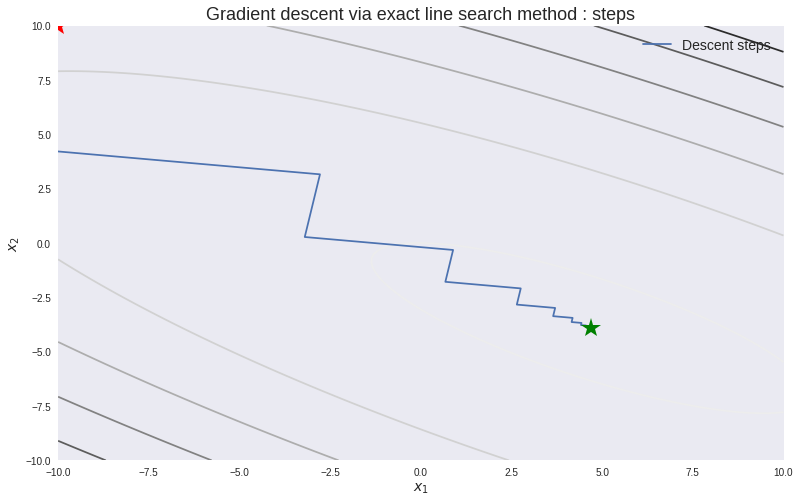

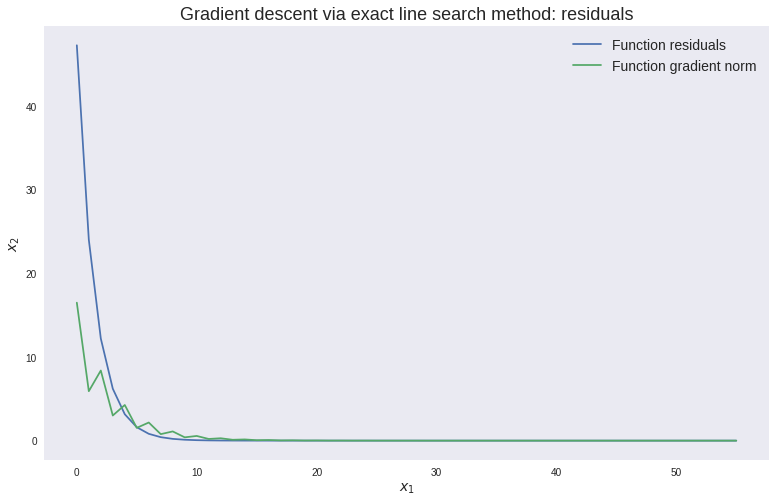

{'x': array([[ 4.68399724],
       [-3.91749549]]), 'f': array([[-7.40639968]]), 'iters': 55, 'success': True, 'method': 'gradient-descent'}


In [635]:
gd = Descent(coordinate_descent['function'], coordinate_descent['gradient'], step_chooser=gradient_descent['opt_step'])
res_gd = gd.optimize(x_start, max_iter=400, tol=1e-7, method='gradient-descent')

plot_results(optimizer=gd, title='Gradient descent via exact line search method')
print(res_gd)

In [ ]:
# Gradient descent via golden ration method
function = lambda x: 0.5 * x.T @ Q @ x + c.T @ x
gradient = lambda x: Q @ x + c

def gss(*args):
    '''
    golden section search
    to find the minimum of f on [a,b]
    f: a strictly unimodal function on [a,b]

    example:
    >>> f = lambda x: (x-2)**2
    >>> x = gss(f, 1, 5)
    >>> x
    2.000009644875678

    '''

    x = args[0]
    grad = args[1]

    gr = (math.sqrt(5) + 1) / 2
    a, b = -100, 100
    tol = 1e-4

    c = b - (b - a) / gr
    d = a + (b - a) / gr
    while np.abs(c - d) > tol:
        if function(x - c * grad) < function(x - d * grad):
            b = d
        else:
            a = c

        # we recompute both c and d here to avoid loss of precision which may lead to incorrect results or infinite loop
        c = b - (b - a) / gr
        d = a + (b - a) / gr

    return (b + a) / 2


gradient_descent = {
    'function': function,
    'gradient': gradient,
    'opt_step': gss
}

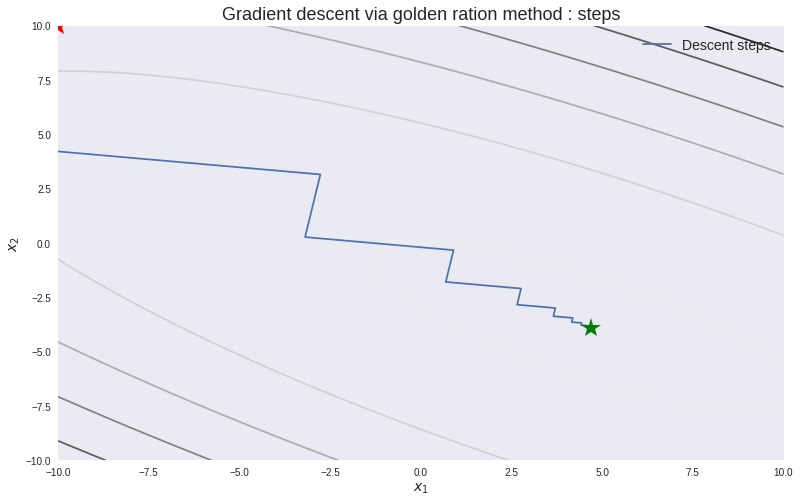

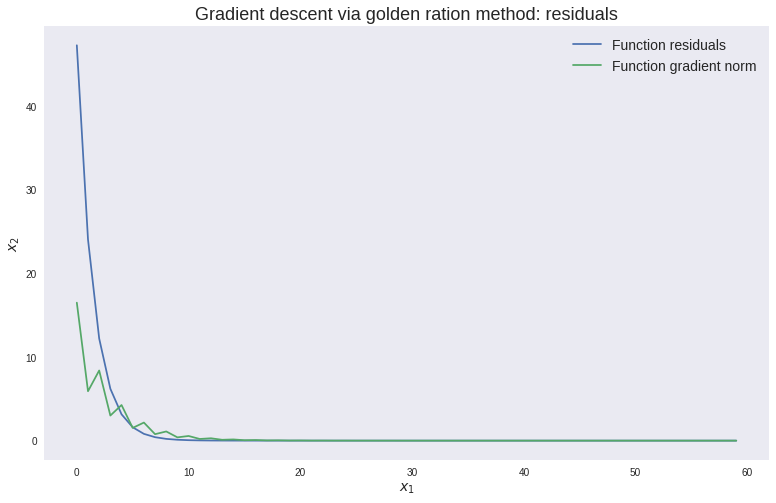

{'x': array([[ 4.68399729],
       [-3.91749552]]), 'f': array([[-7.40639968]]), 'iters': 59, 'success': True, 'method': 'gradient-descent'}


In [645]:
gd = Descent(gradient_descent['function'], gradient_descent['gradient'], step_chooser=gradient_descent['opt_step'])
res_gd = gd.optimize(x_start, max_iter=400, tol=1e-7, method='gradient-descent')

plot_results(optimizer=gd, title='Gradient descent via golden ration method')
print(res_gd)

In [ ]:
# Gradient descent via Armijo rule
function = lambda x: 0.5 * x.T @ Q @ x + c.T @ x
gradient = lambda x: Q @ x + c

def armijo_rule_step(*args):

    x = args[0]
    p = args[1]

    beta = 0.5

    t = -beta * p.T @ p

    armijo_rule = lambda alpha: (function(x) - function(x + alpha * p))[0, 0] >= alpha * t

    while armijo_rule(beta):
        beta *= t

    return beta


gradient_descent = {
    'function': function,
    'gradient': gradient,
    'opt_step': armijo_rule_step
}

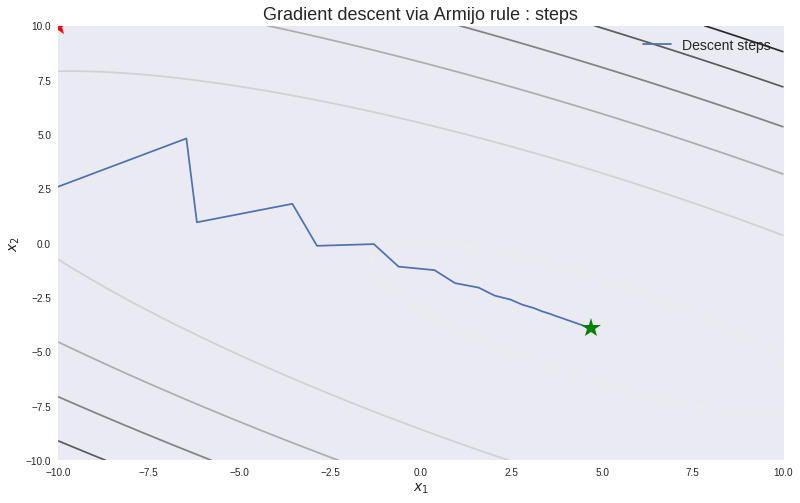

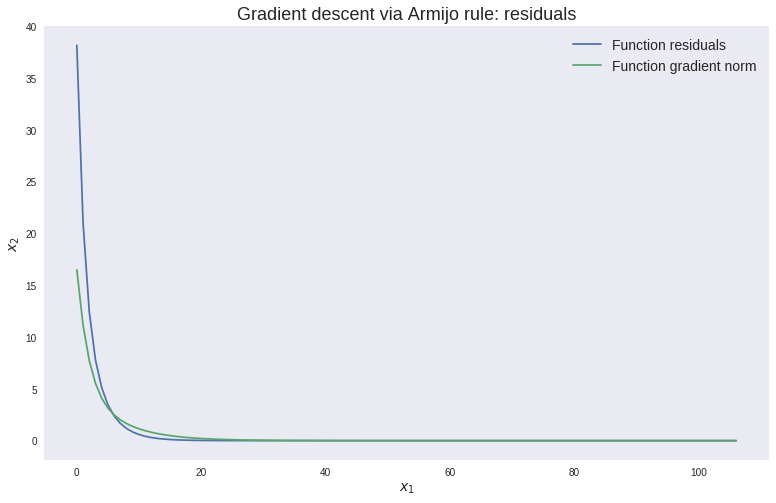

{'x': array([[ 4.68399716],
       [-3.91749543]]), 'f': array([[-7.40639968]]), 'iters': 106, 'success': True, 'method': 'gradient-descent'}


In [647]:
gd = Descent(gradient_descent['function'], gradient_descent['gradient'], step_chooser=gradient_descent['opt_step'])
res_gd = gd.optimize(x_start, max_iter=400, tol=1e-7, method='gradient-descent')

plot_results(optimizer=gd, title='Gradient descent via Armijo rule')
print(res_gd)

In [ ]:
# Coordinate descent via exact line search
function = lambda x: 0.5 * x.T @ Q @ x + c.T @ x
gradient = lambda x: Q @ x + c

def exact_line_search_opt_step(x, *args):
    p = args[0]
    return -(2 * c.T @ p + x.T @ Q @ p + p.T @ Q @ x) / (2 * p.T @ Q @ p)

coordinate_descent = {
    'function': function,
    'gradient': gradient,
    'opt_step': exact_line_search_opt_step
}

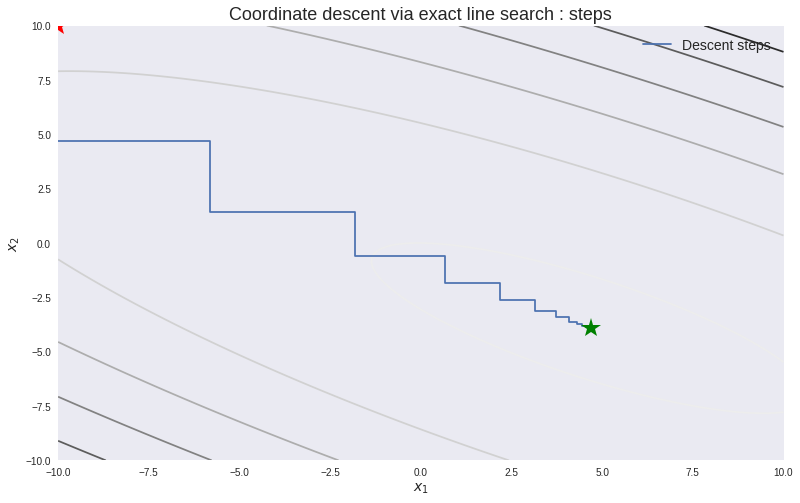

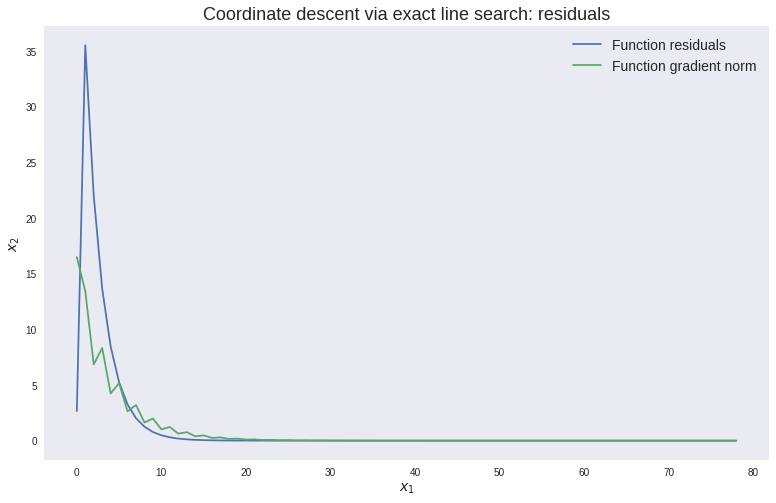

{'x': array([[ 4.6839972 ],
       [-3.91749547]]), 'f': array([[-7.40639968]]), 'iters': 78, 'success': True, 'method': 'coordinate-descent'}


In [649]:
cd = Descent(coordinate_descent['function'], coordinate_descent['gradient'], step_chooser=coordinate_descent['opt_step'])
res_cd = cd.optimize(x_start, max_iter=400, tol=1e-7, method='coordinate-descent')

plot_results(optimizer=cd, title='Coordinate descent via exact line search')
print(res_cd)

In [ ]:
# Coordinate descent via Fibbonachi method
function = lambda x: 0.5 * x.T @ Q @ x + c.T @ x
gradient = lambda x: Q @ x + c


def fibonacci_method(*args):

    N = 50
    a, b = -100, 100

    x = args[0]
    p = args[1]

    def fibonacci(n):
        x, y = 0.0, 1.0
        if n < 1.0:
            return 0.0
        if n == 1.0:
            return 1.0

        for _ in range(2, n):

            t = x
            x = y
            y = t + y

        return y

    for i in range(N):
        x_1 = fibonacci(N - i - 1) / fibonacci(N - i + 1) * (b - a) + a
        x_2 = fibonacci(N - i) / fibonacci(N - i + 1) * (b - a) + a

        if function(x + x_2 * p) > function(x + x_1 * p):
            b = x_2

        else:
            a = x_1

    return (a + b) / 2


coordinate_descent = {
    'function': function,
    'gradient': gradient,
    'opt_step': fibonacci_method
}

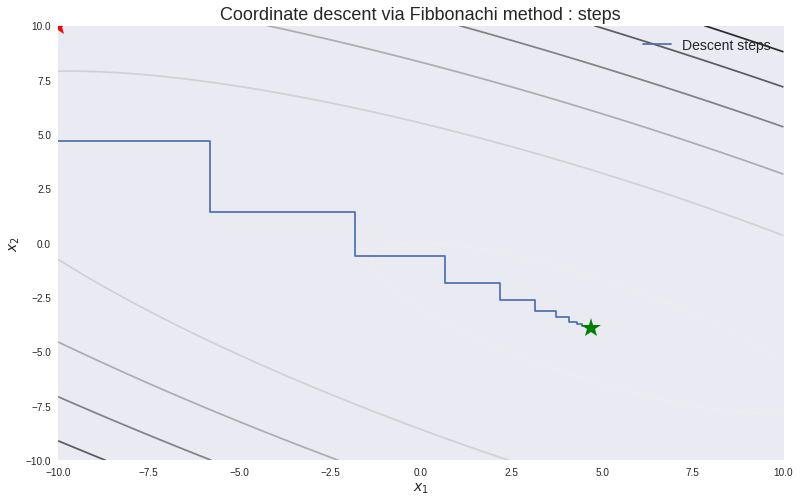

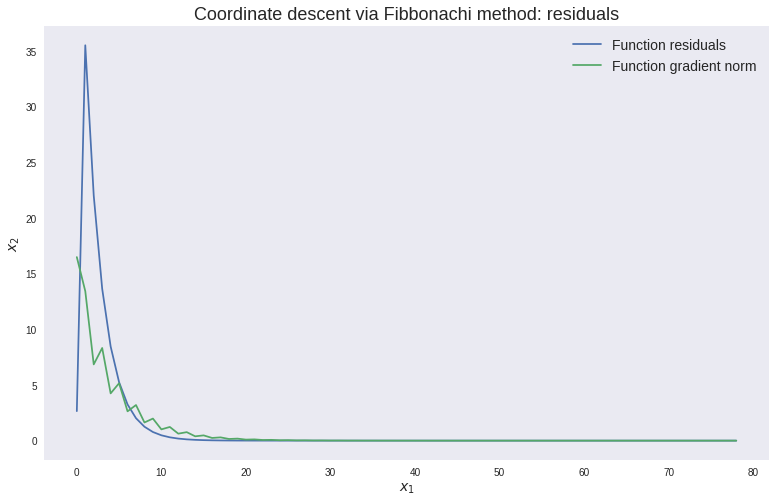

{'x': array([[ 4.6839972 ],
       [-3.91749545]]), 'f': array([[-7.40639968]]), 'iters': 78, 'success': True, 'method': 'coordinate-descent'}


In [651]:
cd = Descent(coordinate_descent['function'], coordinate_descent['gradient'], step_chooser=coordinate_descent['opt_step'])
res_cd = cd.optimize(x_start, max_iter=400, tol=1e-7, method='coordinate-descent')

plot_results(optimizer=cd, title='Coordinate descent via Fibbonachi method')
print(res_cd)

## Task 2

$$
x(t) \in R^n, t = 0, \dots N, u(t) \in R \\
\text{The dynamics of the system }: \\ x(t + 1) = A x(t) + b u(t), t = 0, \dots, N - 1
\text{Task - choose the inputs } u(0), \dots, u(N - 1) \text{ in order to minimize the total fuel consumed } : \\
F = \sum_{t = 0}^{N - 1} f(u(t)) \\
\text{ subject to the constraint that } x(N) = x_{des}. \\
\text{Where }: f(a) = \begin{cases}
  |a|, |a| \leq 1, \\
  2 |a| - 1, |a| \geq 1
\end{cases}
$$

### Task 2.1
Formulate the minimum fuel optimal control problem as an LP.

$$
  x(N) = x_{des}\\
  x(1) = b u(0) \\
  x(2) = A b u(0) + b u(1) \\
  x(3) = A^2 b u(0) + A b u(1) + b u (0) \\
  \vdots \\
  x(N) = A^{N - 1} b u(0) + A^{N - 2} b u(1) + \dots + A b u(N - 1) + b u(N - 1)  \\
  \text{We can define controllability matrix }: \\
  C = \left [ A^{N - 1}b, A^{N - 2}b, \dots mA b, b \right] \text{ and } u^\top = \left [ u(0), \dots u(N - 1) \right] \\ \text{ Problem }: \\
  C u = x_{des} \\
  \text{Now,  turn attention back to } f(a). \text{First, add single variable } t, together with constraints \\
  | a | \leq t \\
  2 | a |  - 1 \leq t \implies \\
  -t \leq a \leq t \\
  -\dfrac{t + 1}{2} \leq a \leq \dfrac{t + 1}{2} \\
  \text{Introduce vector } t = [ t_0, \dots, t_{N - 1} ] \text{  LP is :} \\
  \mathcal{P} = \begin{cases}
    min 1^\top t \\
    \text{ subject to : } \\
      -t \leq u \leq t \\
      -\dfrac{t + 1}{2} \leq u \leq \dfrac{t + 1}{2} \\
      C u = x_{des}
  \end{cases}
$$

### Task 2.2

Calculation and visualization of the results

In [ ]:
import cvxpy
from cvxpy import Variable, Minimize, maximum, abs, sum, Problem

In [ ]:
n = 3
N = 30
A = np.array([[-1, 0.4, 0.8], [1, 0, 0], [0, 1, 0]])
b = np.array([[1, 0, 0.3]]).T
x_des = np.array([7, 2, -6])

In [ ]:
def optimal_control(A, b, x_des, n, N):
  
  X = Variable((n, N+1))
  u = Variable((1, N))

  objective = Minimize(sum(maximum(abs(u), 2 * abs(u) - 1)))

  constraints = [
      X[:, 0] == 0, 
      X[:, 1:] == A * X[:, :N] + b * u,
      X[:, -1] == x_des
  ]

  prob = Problem(objective=objective, constraints=constraints)
  optimal_f = prob.solve()
  
  return optimal_f, X.value, u.value

In [ ]:
optimal_f, x, u = optimal_control(A, b, x_des, n, N)

In [ ]:
def plot_results(x, u, title):
  
  fig, axs = plt.subplots(2, 2)
  
  fig.set_size_inches(23, 13)
  
  axs = axs.flatten()
  
  for i, (ax) in enumerate(axs[:-1]):
    
    ax.step(np.arange(N), x[i, :-1], label=r'$ x_i $')
    ax.set_title('X [{}]'.format(i), fontsize=20)
    ax.set_xlabel('T', fontsize=16)
    ax.set_ylabel('X (T)', fontsize=16)
    ax.legend(fontsize=16)
    
    
  ax = axs[3]
  ax.step(np.arange(N), u[0, :], label='u')
  ax.set_title('u', fontsize=20)
  ax.set_xlabel('T', fontsize=16)
  ax.set_ylabel('U (T)', fontsize=16)
  ax.legend(fontsize=16)
  
  plt.show()

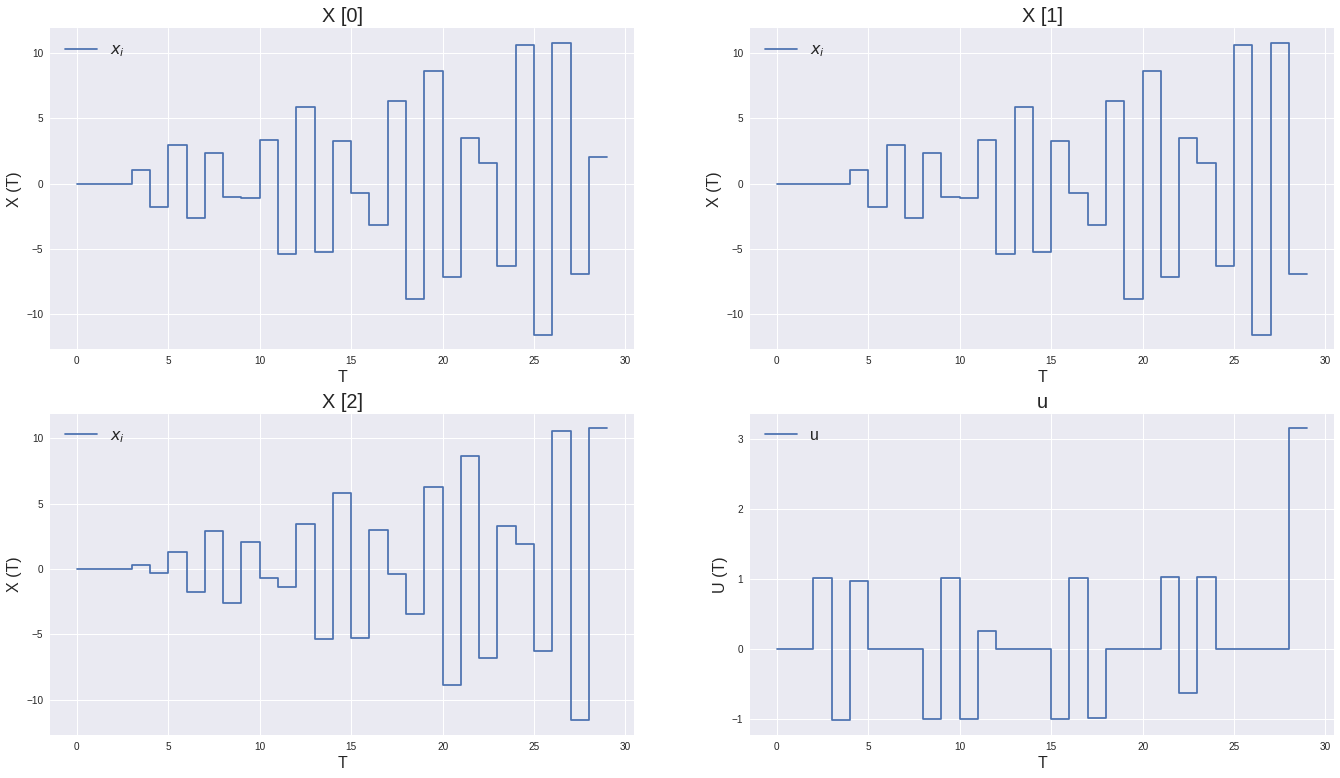

In [657]:
plot_results(x, u, 'asd')

### Task 2.3
Perturbing of $ x_{des} $

Validate this fact numerically by perturbing xdes and analytically (based on largange multiplier values).

Lagrange form:
$$
L(t, u, \alpha, \beta, \gamma, \Delta, \theta, \delta) =  \\ = 1^\top  t - \alpha^\top (u + t) + \beta^\top (u - t) - \gamma^\top (2u + 1 + t) + \Delta^\top (2u - 1 - t) + \theta (C u - x_{des}) + \delta_{R^{4N}_+} \begin{bmatrix} 
  \alpha \\
  \beta \\
  \gamma \\
  \Delta
\end{bmatrix} = \\ = ( -\alpha + \beta - 2 \gamma + 2 \Delta + C^\top \theta)^\top u + (1 - \alpha - \beta - \gamma - \Delta)^\top t - (\gamma^\top 1 + \Delta^\top 1 + \theta^\top x_{des}) +  \delta_{R^{4N}_+} \begin{bmatrix} 
  \alpha \\
  \beta \\
  \gamma \\
  \Delta
\end{bmatrix} 
$$

By definition,
$$ 
g(\alpha, \beta, \gamma, \Delta, \theta, \delta) = \underset{u, t}{inf} = \\ = \underset{u, t}{inf}  \left [  ( -\alpha + \beta - 2 \gamma + 2 \Delta + C^\top \theta)^\top u + (1  - \alpha - \beta - \gamma - \Delta)^\top t - (\gamma^\top 1 + \Delta^\top 1 + \theta^\top x_{des}) + \delta_{R^{4N}_+} \begin{bmatrix} 
  \alpha \\
  \beta \\
  \gamma \\
  \Delta
\end{bmatrix} \right ] = \\ = \underset{u, t}{inf}  \left [  ( -\alpha + \beta - 2 \gamma + 2 \Delta + C^\top \theta)^\top u + (1 - \alpha - \beta - \gamma - \Delta)^\top t - (\gamma^\top 1 + \Delta^\top 1 + \theta^\top x_{des}) + \delta_{R^{4N}_+} \begin{bmatrix} 
  \alpha \\
  \beta \\
  \gamma \\
  \Delta
\end{bmatrix} \right ] = \\ = \underset{u}{inf}  \left [  ( -\alpha + \beta - 2 \gamma + 2 \Delta + C^\top \theta)^\top u \right ] + \underset{t}{inf}  \left [ (1 - \alpha - \beta - \gamma - \Delta)^\top t \right ] - (\gamma^\top 1 + \Delta^\top 1 + \theta^\top x_{des}) + \delta_{R^{4N}_+} \begin{bmatrix} 
  \alpha \\
  \beta \\
  \gamma \\
  \Delta
\end{bmatrix}
$$

At the part of $ t $ part of the expression, we see, that $ (1 - \alpha - \beta - \gamma - \Delta)^\top t = 1^\top t -  ( \alpha + \beta + \gamma + \Delta)^\top t $. In order for $ g $ to be finite, clear, that: $ \alpha + \beta + \gamma + \Delta \leq 1 $. By the same logic, implies, that $  -\alpha + \beta - 2 \gamma + 2 \Delta + C^\top \theta = 0 $
With this condition implies, that:

$$
g(\alpha, \beta, \gamma, \Delta, \theta, \delta) = - (\gamma^\top 1 + \Delta^\top 1 + \theta^\top x_{des}) + \delta_{R^{4N}_+} \begin{bmatrix} 
  \alpha \\
  \beta \\
  \gamma \\
  \Delta
\end{bmatrix}
$$

Then dual problem is:

$$
\mathcal{\hat{P}} = \begin{cases}
  max \left [ \gamma^\top 1 + \Delta^\top 1 + \theta^\top x_{des} \right ] \\
  0 \leq \alpha, \beta, \gamma, \Delta \\
   -\alpha + \beta - 2 \gamma + 2 \Delta + C^\top \theta = 0 \\
   \alpha + \beta + \gamma + \Delta \leq 1 \\
\end{cases}
$$

From the formulation of dual problem we see, that perturbing of $ x_{des} $ influences directly on behavior of $ u $.
This infuence, we can see at the plots below.

In [ ]:
def perturbations(component = 0, l_b = -2, r_b = 2, _n = 4):

  xs = []
  us = []

  dxs = np.linspace(l_b, r_b, _n)

  for dx in dxs:
    _x_des = deepcopy(x_des)
    _x_des[component] += dx
    
    optimal_f, x, u = optimal_control(A, b, _x_des, n, N)
    
    xs += [x]
    us += [u]
    
  return xs, us, dxs

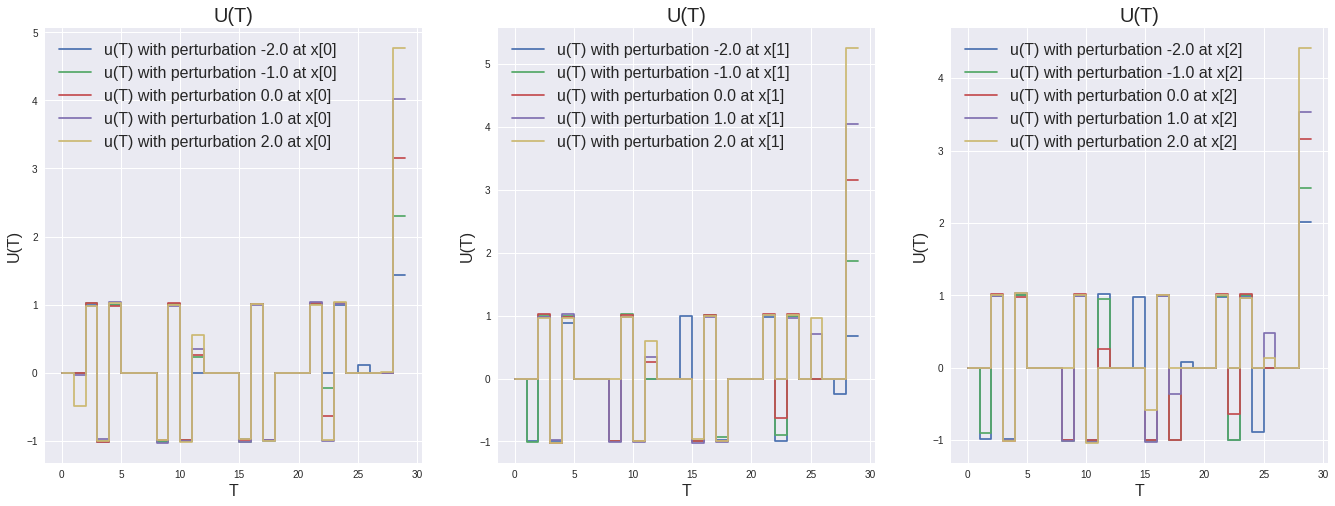

In [659]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(23, 8)  
axs = axs.flatten()
  
for i, (ax) in enumerate(axs):
  
  xs, us, dxs = perturbations(component=i, _n = 5)
  
  for j in range(len(xs)):
    
    ax.step(np.arange(N), us[j][0, :], label='u(T) with perturbation {} at x[{}]'.format(dxs[j], i))
    ax.set_title('U(T)'.format(i), fontsize=20)
    ax.set_xlabel('T', fontsize=16)
    ax.set_ylabel('U(T)', fontsize=16)
    ax.legend(fontsize=16)
    
plt.show()

<strong>Some information and hint are from :
  - https://sites.math.washington.edu/~burke/crs/cvx08/projects/4-16-sasha.pdf